In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
import pickle

import util
from ts_net import TsNet

import logging
logging.basicConfig(level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(name)s: %(message)s")
logger = logging.getLogger(__name__)

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
class Args:
    def __init__(self, data_dir, target_obj, train_mean_std_dir, batch_size, win_size, corr_coef_pp, n_folds, rand_seed, max_epochs, logdir, verbose):
        self.data_dir = data_dir
        self.target_obj = target_obj
        self.batch_size = batch_size
        self.win_size = win_size
        self.corr_coef_pp = corr_coef_pp
        self.n_folds = n_folds
        self.rand_seed = rand_seed
        self.max_epochs = max_epochs
        self.logdir = logdir
        self.verbose = verbose
        self.train_mean_std_dir = train_mean_std_dir

In [3]:
# # configs

# root_dir = "/home/yujin/ts_prediction_keras/data"
data_dir = "../data"
target_object = "Patient_2"
batch_size = 32
win_size = 8000
corr_coef_pp = 0.0
n_folds = 3
rand_seed = 11
max_epochs = 1
logdir = "./log"
verbose = 0
train_mean_std_dir = "../train_mean_std_dir"

args = Args(data_dir = data_dir,
            target_obj = target_object,
            batch_size = batch_size,
            win_size = win_size,
            corr_coef_pp = corr_coef_pp,
            n_folds = n_folds,
            rand_seed = rand_seed,
            max_epochs = max_epochs,
            logdir = logdir,
            verbose = verbose,
            train_mean_std_dir = train_mean_std_dir
           )

np.random.seed(args.rand_seed)

In [ ]:
# run the entire program

from run import main
main(args)

2017-04-24 00:22:17,878 [INFO] run: target_data_dir=../data/Patient_2
2017-04-24 00:22:17,879 [INFO] util: #preictal_files = 18
2017-04-24 00:22:17,879 [INFO] util: #interictal_files = 42
2017-04-24 00:22:17,880 [INFO] util: Loading preictal data from ../data/Patient_2 ...
2017-04-24 00:22:17,881 [INFO] util: filename=../data/Patient_2/Patient_2_preictal_segment_0001.mat
2017-04-24 00:22:18,163 [INFO] util: filename=../data/Patient_2/Patient_2_preictal_segment_0002.mat
2017-04-24 00:22:18,445 [INFO] util: filename=../data/Patient_2/Patient_2_preictal_segment_0003.mat
2017-04-24 00:22:18,727 [INFO] util: filename=../data/Patient_2/Patient_2_preictal_segment_0004.mat
2017-04-24 00:22:19,009 [INFO] util: filename=../data/Patient_2/Patient_2_preictal_segment_0005.mat
2017-04-24 00:22:19,290 [INFO] util: filename=../data/Patient_2/Patient_2_preictal_segment_0006.mat
2017-04-24 00:22:19,572 [INFO] util: filename=../data/Patient_2/Patient_2_preictal_segment_0007.mat
2017-04-24 00:22:19,854 [I

Epoch 00000: val_prob_loss improved from inf to 0.67975, saving model to ./log/Patient_2_20170424002217/model/bestmodel_fold0.h5


2017-04-24 00:23:56,568 [INFO] run: #test_files = 150
2017-04-24 00:23:56,569 [INFO] run: Load model to test
2017-04-24 00:23:56,744 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0001.mat
2017-04-24 00:23:57,710 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0002.mat
2017-04-24 00:23:58,385 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0003.mat
2017-04-24 00:23:59,056 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0004.mat
2017-04-24 00:23:59,724 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0005.mat
2017-04-24 00:24:00,395 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0006.mat
2017-04-24 00:24:01,065 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0007.mat
2017-04-24 00:24:01,734 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0008.mat
2017-04-24 00:24:02,406 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0009.mat
2017-04-24 00:24:03,079 [IN

In [4]:
logdir, modeldir = util.create_log(args.logdir, args.target_obj)

In [5]:
target_data_dir = os.path.join(args.data_dir, args.target_obj)
logger.info("target_data_dir={}".format(target_data_dir))
data, labels = util.load_train_data(target_data_dir)
train_ix, valid_ix = util.split_to_folds(labels, n_folds=args.n_folds)

2017-04-24 00:16:59,887 [INFO] __main__: target_data_dir=../data/Patient_2
2017-04-24 00:16:59,889 [INFO] util: #preictal_files = 18
2017-04-24 00:16:59,891 [INFO] util: #interictal_files = 42
2017-04-24 00:16:59,892 [INFO] util: Loading preictal data from ../data/Patient_2 ...
2017-04-24 00:16:59,893 [INFO] util: filename=../data/Patient_2/Patient_2_preictal_segment_0001.mat
2017-04-24 00:17:00,189 [INFO] util: filename=../data/Patient_2/Patient_2_preictal_segment_0002.mat
2017-04-24 00:17:00,470 [INFO] util: filename=../data/Patient_2/Patient_2_preictal_segment_0003.mat
2017-04-24 00:17:00,752 [INFO] util: filename=../data/Patient_2/Patient_2_preictal_segment_0004.mat
2017-04-24 00:17:01,034 [INFO] util: filename=../data/Patient_2/Patient_2_preictal_segment_0005.mat
2017-04-24 00:17:01,318 [INFO] util: filename=../data/Patient_2/Patient_2_preictal_segment_0006.mat
2017-04-24 00:17:01,604 [INFO] util: filename=../data/Patient_2/Patient_2_preictal_segment_0007.mat
2017-04-24 00:17:01,8

In [6]:
num_seq, seq_len, num_ch = data.shape
print num_seq, seq_len, num_ch

60 3000000 24


In [7]:
# from keras.models import Model
# from keras.layers import Input, Lambda, Flatten, Reshape
# input_data = Input(shape=data.shape[1:], dtype="float32")
# logger.info(input_data.shape)
# data_mean = Lambda(lambda x: K.mean(x))(input_data)
# data_std = Lambda(lambda x: K.std(x))(input_data)
# mm = Model(input_data, [data_mean, data_std])

In [8]:
npzfile_path = os.path.join(args.train_mean_std_dir, args.target_obj, "train_mean_std.npz")
npzfile = np.load(npzfile_path)
train_mean = npzfile["train_mean"]
train_std = npzfile["train_std"]

In [9]:
# for fold_i in xrange(args.n_fold):
fold_i = 0
logger.info("<fold {}>".format(fold_i))
logger.info("---------------")
# load data
train_data, train_labels = data[train_ix[fold_i]], labels[train_ix[fold_i]]
valid_data, valid_labels = data[valid_ix[fold_i]], labels[valid_ix[fold_i]]
# build net
logger.info("Build model")
model = TsNet(args, train_mean, train_std, num_ch)
model.build_model()
model.build_func()
# train
logger.info("Start to train")
modelname = "bestmodel_fold" + str(fold_i) + ".h5"
train_hist = model.train(train_data, train_labels, valid_data, valid_labels,
                             logdir, os.path.join(logdir, "model", modelname))
hist_file = os.path.join(logdir, "hist_fold"+str(fold_i)+".pkl")
with open(hist_file, "wb") as f:
    pickle.dump(train_hist.history, f)

2017-04-24 00:17:19,140 [INFO] __main__: <fold 0>
2017-04-24 00:17:19,142 [INFO] __main__: ---------------
2017-04-24 00:17:20,515 [INFO] __main__: Build model
2017-04-24 00:17:20,827 [INFO] ts_net: [<tf.Tensor 'corr_pp/Mean_2:0' shape=() dtype=float32>, <tf.Tensor 'corr_pp_1/Mean_2:0' shape=() dtype=float32>, <tf.Tensor 'corr_pp_2/Mean_2:0' shape=() dtype=float32>, <tf.Tensor 'prob/Sigmoid:0' shape=(?, 1) dtype=float32>]
2017-04-24 00:17:20,828 [INFO] ts_net: [0.0, 0.0, 0.0, 1.0]
2017-04-24 00:17:20,883 [INFO] __main__: Start to train
2017-04-24 00:17:20,884 [INFO] ts_net: max_epochs=1, steps_per_epoch=468, validation_steps=468
2017-04-24 00:17:21,954 [INFO] ts_net: pos_sampling_weight=2.33333333333
2017-04-24 00:17:21,955 [INFO] ts_net: data_fetcher off to work
2017-04-24 00:18:14,675 [INFO] ts_net: pos_sampling_weight=2.33333333333
2017-04-24 00:18:14,676 [INFO] ts_net: data_fetcher off to work


Epoch 00000: val_prob_loss improved from inf to 0.68764, saving model to ./log/Patient_2_20170424001657/model/bestmodel_fold0.h5


In [10]:
# test
logger.info("Load model to test")
model.model.load_weights(os.path.join(logdir, "model", modelname))
del train_data, train_labels, valid_data, valid_labels
import gc
gc.collect()

2017-04-24 00:18:45,071 [INFO] __main__: Load model to test


0

In [14]:
data_files = os.listdir(target_data_dir)
test_data_files = np.sort([f for f in data_files if "test" in f])
logger.info("#test_files = {}".format(test_data_files.size))
# test_data = util.load_all_data(target_data_dir, "test")
# logger.info("test_data.shape={}".format(test_data.shape))
preds = model.test_on_data(test_data_files, seq_len, num_ch)
output = pd.Series(preds, index=test_data_files)
output_file = os.path.join(logdir, "output_fold"+str(fold_i)+".csv")
output.to_csv(output_file)
logger.info("Test result written to {}.".format(output_file))
# del test_data

2017-04-24 00:21:42,740 [INFO] __main__: #test_files = 150
2017-04-24 00:21:42,742 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0001.mat
2017-04-24 00:21:43,695 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0002.mat
2017-04-24 00:21:45,137 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0003.mat
2017-04-24 00:21:46,569 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0004.mat
2017-04-24 00:21:47,996 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0005.mat
2017-04-24 00:21:49,456 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0006.mat
2017-04-24 00:21:50,887 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0007.mat
2017-04-24 00:21:52,317 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0008.mat
2017-04-24 00:21:53,722 [INFO] util: filename=../data/Patient_2/Patient_2_test_segment_0009.mat
2017-04-24 00:21:55,153 [INFO] util: filename=../data/Patient_2/Patient_2_tes

KeyboardInterrupt: 

In [29]:
from run import merge_results
res = merge_results(logdir)
!ls -ltrh $logdir

total 136K
-rw-rw-r-- 1 yujin yujin  11K Apr 23 17:13 hist_fold0.pkl
-rw-rw-r-- 1 yujin yujin  22K Apr 23 17:16 output_fold0.csv
-rw-rw-r-- 1 yujin yujin  11K Apr 23 17:29 hist_fold1.pkl
-rw-rw-r-- 1 yujin yujin  22K Apr 23 17:32 output_fold1.csv
drwxrwxr-x 2 yujin yujin 4.0K Apr 23 17:33 model
-rw-rw-r-- 1 yujin yujin  11K Apr 23 17:44 hist_fold2.pkl
-rw-rw-r-- 1 yujin yujin  22K Apr 23 17:47 output_fold2.csv
-rw-rw-r-- 1 yujin yujin  22K Apr 23 18:01 csv_to_submit.csv


True
True


In [7]:
modelname = "bestmodel_fold" + str(fold_i) + ".h5"
train_hist = model.train(logdir, os.path.join(logdir, "model", modelname))

2017-04-23 16:34:37,077 [INFO] ts_net: max_epochs=20, steps_per_epoch=314, validation_steps=157
2017-04-23 16:34:38,177 [INFO] ts_net: data_fetcher off to work
2017-04-23 16:35:10,196 [INFO] ts_net: data_fetcher off to work


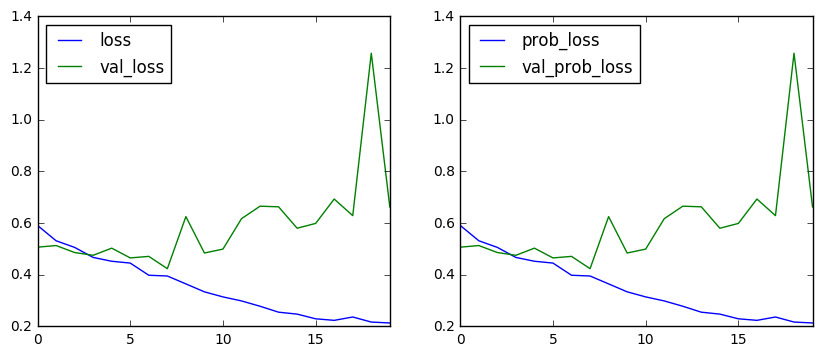

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pd.DataFrame({"loss": train_hist.history["loss"], "val_loss": train_hist.history["val_loss"]}).plot(ax=axes[0])
pd.DataFrame({"prob_loss": train_hist.history["prob_loss"], "val_prob_loss": train_hist.history["val_prob_loss"]}).plot(ax=axes[1])

In [9]:
model.model.load_weights(os.path.join(logdir, "model", modelname))

In [11]:
data_files = os.listdir(target_data_dir)
test_data_files = np.sort([f for f in data_files if "test" in f])
logger.info("#test_files = {}".format(test_data_files.size))
test_data = util.load_all_data(target_data_dir, "test")
logger.info("test_data.shape={}".format(test_data.shape))

2017-04-23 16:43:01,067 [INFO] __main__: #test_files = 502
2017-04-23 16:43:01,068 [INFO] data_util: Loading test data from /home/yujin/ts_prediction_keras/data/Dog_1 ...
2017-04-23 16:43:01,071 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0001.mat
2017-04-23 16:43:01,349 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0002.mat
2017-04-23 16:43:01,406 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0003.mat
2017-04-23 16:43:01,469 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0004.mat
2017-04-23 16:43:01,532 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0005.mat
2017-04-23 16:43:01,596 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_test_segment_0006.mat
2017-04-23 16:43:01,659 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog

In [12]:
preds = model.test_on_data(test_data)

In [15]:
output = pd.Series(preds, index=test_data_files)
output_file = os.path.join(logdir, "output_fold"+str(fold_i)+".csv")
output.to_csv(output_file)
logger.info("Test result written to {}.".format(output_file))

2017-04-23 16:49:19,909 [INFO] __main__: Test result written to ./log/Dog_1_20170423163401/output_fold0.csv.


In [18]:
import pickle

hist_file = os.path.join(logdir, "hist_fold"+str(fold_i)+".pkl")
with open(hist_file, "wb") as f:
    pickle.dump(train_hist.history, f)

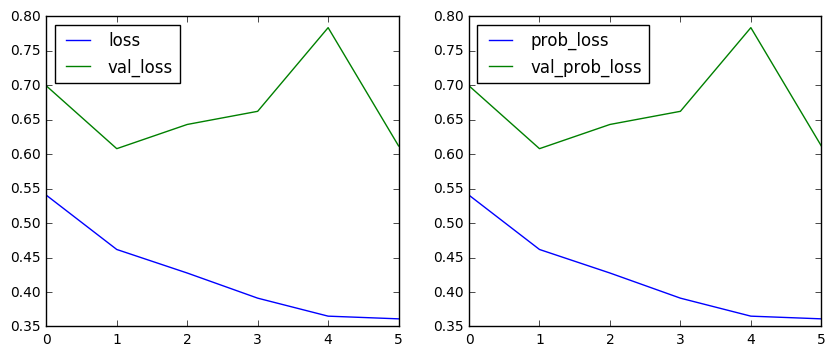

In [20]:
with open(hist_file, "rb") as f:
    hh = pickle.load(f)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pd.DataFrame({"loss": hh["loss"], "val_loss": hh["val_loss"]}).plot(ax=axes[0])
pd.DataFrame({"prob_loss": hh["prob_loss"], "val_prob_loss": hh["val_prob_loss"]}).plot(ax=axes[1])

In [22]:
layer_info = [(idx, layer.name, layer.output_shape) for idx, layer in enumerate(model.model.layers)]

logger.info("<Model architecture>")
for idx, name, shape in layer_info:
    logger.info("#{}: name={}, shape={}".format(idx, name, shape))

logger.info("<Model metrics>")
logger.info("metrics_names={}".format(model.model.metrics_names))

2017-04-23 15:57:57,166 [INFO] __main__: <Model architecture>
2017-04-23 15:57:57,168 [INFO] __main__: #0: name=data, shape=(None, 8000, 16)
2017-04-23 15:57:57,169 [INFO] __main__: #1: name=normalization, shape=(None, 8000, 16)
2017-04-23 15:57:57,171 [INFO] __main__: #2: name=conv1, shape=(None, 8000, 32)
2017-04-23 15:57:57,172 [INFO] __main__: #3: name=max_pooling1d_1, shape=(None, 2000, 32)
2017-04-23 15:57:57,173 [INFO] __main__: #4: name=pos_data1, shape=(None, 8000, 16)
2017-04-23 15:57:57,174 [INFO] __main__: #5: name=pos_data2, shape=(None, 8000, 16)
2017-04-23 15:57:57,174 [INFO] __main__: #6: name=conv2, shape=(None, 2000, 64)
2017-04-23 15:57:57,175 [INFO] __main__: #7: name=max_pooling1d_2, shape=(None, 1000, 64)
2017-04-23 15:57:57,176 [INFO] __main__: #8: name=conv3, shape=(None, 1000, 64)
2017-04-23 15:57:57,177 [INFO] __main__: #9: name=max_pooling1d_3, shape=(None, 500, 64)
2017-04-23 15:57:57,178 [INFO] __main__: #10: name=flatten, shape=(None, 32000)
2017-04-23 15:

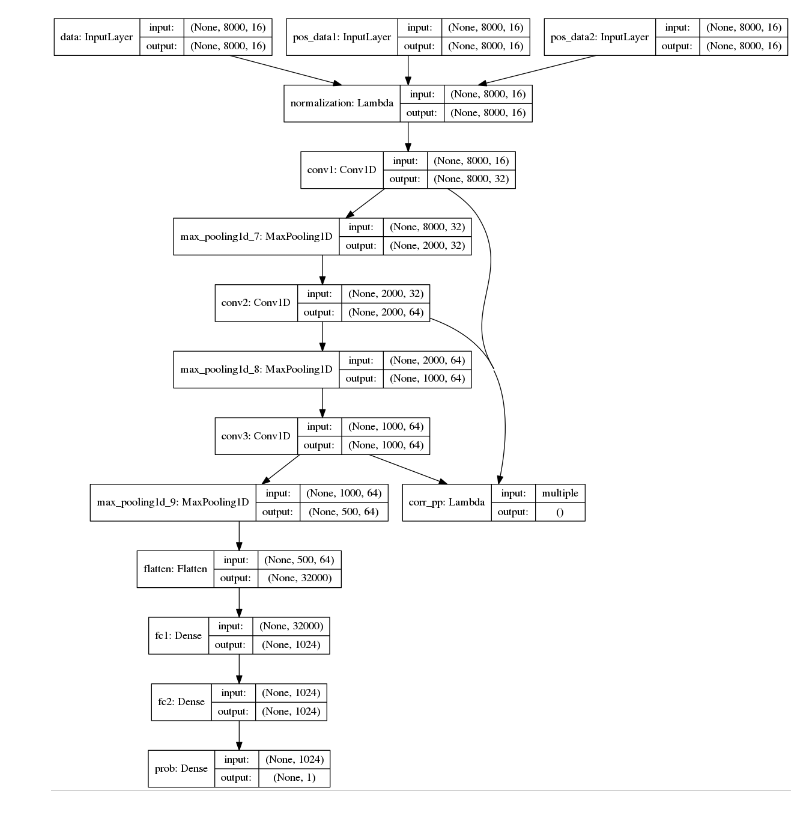

In [22]:
from keras.utils import plot_model
plot_model(model.model, to_file='model.png', show_shapes=True)
model_arch = plt.imread("model.png")
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(model_arch)
ax.set_axis_off()